This is a demo version of Skip_Gram model combined with Negative Sampling, the purpose of code is to illustrate how the model is used.

In [21]:
import torch
from collections import Counter
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.nn as nn
import torch.optim as optim

# Suppose we have a corpus of sentences
texts = [
    "I love machine learning",
    "I love deep learning",
    "deep learning is amazing",
    "machine learning and deep learning are related",
]

class Word2Vec(Dataset):
    def __init__(self, sentences, window_size):
        self.window = window_size
        self.vocab = Counter()
        self.pairs = []
    
        for sentence in sentences:
            words = sentence.lower().split()
            self.vocab.update(words)
            for i, word in enumerate(words):
                start = max(0, i - window_size)
                end = min(len(words), i + window_size + 1)
                for j in range(start, end):
                    if j != i:
                        self.pairs.append((word, words[j]))
        self.word_to_idx = {word: idx for idx, (word, _) in enumerate(self.vocab.items())}
        self.idx_to_word = {idx: word for word, idx in self.word_to_idx.items()}
        self.vocab_size = len(self.vocab)
        
    def __getitem__(self, idx):
        center_word, context_word = self.pairs[idx]
        return self.word_to_idx[center_word], self.word_to_idx[context_word]
    
    def __len__(self):
        return len(self.pairs)
    #if we don't initialize __len__, we can not call len(dataloader) or loop through the dataset
dataset = Word2Vec(texts, 2)


In [ ]:
for x in dataset:
    print(x)
#(0, 1)
(0, 2)
(1, 0)
(1, 2)
(1, 3)
(2, 0)
(2, 1)
(2, 3)

We preprocess the corpus (sentences) to serve training

In [139]:
import re
def preprocess_corpus(corpus):
    # Tokenize and lowercase
    tokens = [re.findall(r'\b\w+\b', sentence.lower()) for sentence in corpus]
    # Flatten the list of lists
    words = [word for sentence in tokens for word in sentence]
    # Create a frequency dictionary
    word_freq = Counter(words)
    # Create vocabulary
    vocab = {word: i for i, (word, _) in enumerate(word_freq.items())}
    return tokens, vocab
tokens, vocab = preprocess_corpus(texts)
vocab

{'i': 0,
 'love': 1,
 'machine': 2,
 'learning': 3,
 'deep': 4,
 'is': 5,
 'amazing': 6,
 'and': 7,
 'are': 8,
 'related': 9}

We need to get negative_sampling pairs for the center words, the negative value are generated ranomly following the below code.

In [127]:
def get_negative_sampling(context_words, vocab_size, num_negative):
    negatives = []
    #given the context words, choose the the amount of negative sample with num_negative quantity
    #just need to be different from context_words
    #can modify to add more conditions
    while len(negatives) < num_negative:
        random_sampling = np.random.randint(0, vocab_size)
        if random_sampling != context_words:
            negatives.append(random_sampling)
    return negatives
    

With pairs of center-context and center-negatives, we calculate the loss

In [110]:
class SkipGramNegSampling(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramNegSampling, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.output_embeddings = nn.Embedding(vocab_size, embedding_dim)
    
    def forward(self, center_words, context_words, negative_samples):
        center_embed = self.embeddings(center_words)  # [batch_size, embedding_dim]
        context_embed = self.output_embeddings(context_words)  # [batch_size, embedding_dim]
        neg_embed = self.output_embeddings(negative_samples)  # [batch_size, window_size, embedding_dim]
        
        # Positive score (for context words)
        pos_score = torch.mul(center_embed, context_embed).sum(dim=-1)  # [batch_size x 1]
        pos_score = torch.sigmoid(pos_score)  # [batch_size x 1]
        
        # Negative score (for negative samples)
        neg_score = torch.bmm(neg_embed, center_embed.unsqueeze(2)).squeeze()  # [batch_size, window_size]
        neg_score = torch.sigmoid(-neg_score).sum(dim=-1)  # [batch_size x 1]

        # Combine the loss
        loss = -torch.log(pos_score) - torch.log(neg_score)
        return loss.mean()

In [129]:
model = SkipGramNegSampling(len(vocab), 10)
optimizer = optim.Adam(model.parameters(), lr = 0.001)


Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [114]:
import numpy as np
def prepare_batch(pairs, vocab_size, num_negative_samples):
    context_words = []
    center_words  = []
    negative_samples = []
    one_sampling = []
    for x in pairs:
        #x[0]: center, x[1]: context
        center_words.append(x[0])
        context_words.append(x[1])
        negative_samples.append(get_negative_sampling(x[1], vocab_size, num_negative_samples))
    return center_words, context_words, negative_samples



In [123]:
from torch.nn.utils.rnn import pad_sequence
data = prepare_batch(dataset, len(vocab), 2)
#len(data) = 3
center_words = torch.tensor(data[0], dtype = torch.long) #pairs
context_words = torch.tensor(data[1], dtype = torch.long) #pairs
neg_samples = torch.tensor(data[2], dtype = torch.long) #pairs x window_size
neg_samples.shape

torch.Size([52, 2])

In [124]:
loss = model(center_words, context_words, neg_samples)
loss

tensor(1.7223, grad_fn=<MeanBackward0>)

Here I am testing the dimension of negatives, center, context word because I code from scratch so the dimensions must be right.

In [ ]:
x = nn.Embedding(len(vocab), 4)
neg_result = x(neg_samples)
cen_result = x(center_words)
neg_result.shape #52x3x4
cen_result.shape #52x4 -> batch_size x embed_value
context_result.shape #52x4 -> batch_size x embed_value
#batch_size x total neg_sam x embed_value


A training loop in pytorch will be:
-> for epoch in range(...)
An epoch with go through the whole batches of data, for each batch, we need to set the initial state of parameters, because each batch is independent -> optimzizer.zero_grad()
After a whole bunch of process, we do back propagation to update weights -> loss.backward(), then we will save it by optimizer.step()

In [ ]:
epochs = 100
for epoch in range(epochs):
    total_loss = 0
    for center, context in dataset:
        center_word_tensor = torch.tensor([center], dtype=torch.long)
        context_word_tensor = torch.tensor([context], dtype=torch.long)
        neg_samples_tensor = torch.tensor(get_negative_sampling(context, len(vocab), 2), dtype=torch.long).unsqueeze(0)
        optimizer.zero_grad()
        loss = model(center_word_tensor, context_word_tensor, neg_samples_tensor)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        print(f'Epoch {[epoch+1]}, Loss: {total_loss/len(dataset):.4f}')

After training we have things like this:
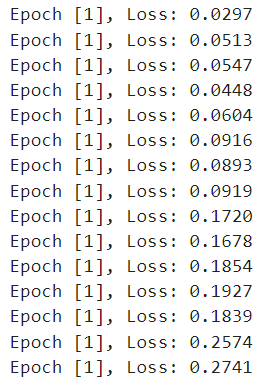

In [142]:
#model.embeddings.weight.data.shape -> embed_dim x embed_dim

torch.Size([10, 10])

In [148]:
#NOW WE WILL FIND SIMILAR WORDS GIVEN AN INPUT WORD
def find_similar_word(word, vocab, model, top_n = 2):
    word_idx = vocab[word]
    word_embedding = model.embeddings(torch.tensor(word_idx))
    similarities = torch.matmul(model.embeddings.weight.data, word_embedding)
    top_similarities, top_indices = torch.topk(similarities, top_n + 1)  # +1 because the word itself will have the highest similarity
    similar_words = []
    for idx in top_indices:
        for w, i in vocab.items():
            if i == idx.item() and w != word:
                similar_words.append(w)
    
    return similar_words

similar_words = find_similar_word('i', vocab, model)
print("Words similar to 'quick':", similar_words)

Words similar to 'quick': ['deep', 'are']


Ok this code is trash, I made it just to under stand how the data is processed with the exact dimension, how to code from scratch!